# <span style="color:purple">Week 3 -- Clustering & Topic Modeling</span> 
### <span style="color:purple">SunnyJy's Movie Kingdom</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>

![title](M.jpg)

<span style="color:purple"> **Brief description of my work:** <br>
In this project, I will study the clustering and topic modeling through movie reviews. I collect movies whoes main genre belongs to comedy, animation, action, and crime. I sellect these four genres purposefully because IMBD has a list of genres which are quite close to each other. I try to find four more distinct genres so that the movies and critics I scrape will have sufficient large differences for clustering. Meanwhile, comedy and animation are closer to each other and crime and action are closer to each other. I would like to see how the clusterings look like and whether it will capture this. <br>
I will do the following things. <br>
**(1)** Use web scraping to scrape Movies on [IMDB](http://www.imdb.com/) to collect information including Movie's title, genre, and 1 movie critics. The information will be recorded in a DataFrame. In total, there are 4 categories of genres, and each genre has 50 movie critics.<br>
**(2)** Flat Clustering Analysis <br>
**(3)** Hierarchical Clustering Analysis <br>
**(4)** Topic Modeling <br>
</span>

### <span style="color:red"> Notice: 
<span style="color:red">**I have uploaded the scraped data already. It is called *MovieKingdom.csv*. ** <br>
**But just in case it cannot be used. Please uncomment my scrapnig code in the APPENDIX section at the end of this file to gather the data first. Thank you!!**

In [10]:
#Special module written for this class    
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# For web scraping
from bs4 import BeautifulSoup
import requests #for http requests
from requests import get
import pandas #gives us DataFrames
import re #for regexs
import numpy as np #math calculation
import urllib

import matplotlib.pyplot as plt

# <span style="color:purple">Flat Clustering Analysis
## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? a

In [11]:
# load DataFrame Movie_Kingdom
Movie_Kingdom = pandas.read_csv('MovieKingdom.csv')
del Movie_Kingdom['Unnamed: 0']
category = ['comedy','crime','action','animation']

### <span style="color:purple"> Tf-idf Parameters
<span style="color:purple"> I have set the parameters of *sklearn.feature_extraction.text.TfidfVectorizer* as below:<br>
 * <span style="color:purple">max_df=0.5 -- ignore terms whose proportions are strictly higher 0.5. <br>
 * <span style="color:purple">min_df=3 -- ignore terms whose frequencies are strictly lower 3 times. <br>
 * <span style="color:purple">max_features=1000 -- only consider the top 1000 ordered by term frequency across the corpus.<br>

In [12]:
# Count Vectorizer
MovieCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
MovieVects = MovieCountVectorizer.fit_transform(Movie_Kingdom['Movie Critic'])

# Tf-idf Transformer
MovieTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(MovieVects)
MovieTF = MovieTFTransformer.transform(MovieVects)

# Tf-idf Vectorizer
MovieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
MovieTFVects = MovieTFVectorizer.fit_transform(Movie_Kingdom['Movie Critic'])

In [13]:
# number of clusters
num_Clusters = len(set(Movie_Kingdom['Movie Category']))

# initialize K-means
km = sklearn.cluster.KMeans(n_clusters=num_Clusters, init='k-means++')
km.fit(MovieTFVects)

# Metrics to evaluate the clusters
#print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print('Cluster Evaluation -- Kmeans')
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Movie_Kingdom['Movie Category'], km.labels_)))

Cluster Evaluation -- Kmeans
Homogeneity: 0.020
Completeness: 0.028
V-measure: 0.023
Adjusted Rand Score: -0.002


### <span style="color:purple"> **Analysis of the Metrics Results** </span>
<span style="color:purple">The result here tends to be less desirable as the values of Homogeniety, Completeness, V-measure are too small. The adjusted rand score is even negative. <br>
I will compare this flat clustering by Kmeans and the hierarchical clustering by fcluster in Exercise 2, and it shows that the later performs better the the Kmeans here. More details come later. 

In [14]:
km.fit(MovieTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
# predict the k-means
Movie_Kingdom['Kmeans Prediction'] = km.labels_

# Top terms in each cluster
terms = MovieTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_Clusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 ebert
 test
 xa0
 club
 members
 action
 films
 named
 hand
 don


Cluster 1:
 season
 episodes
 episode
 netflix
 things
 nthe
 shows
 ve
 family
 000000


Cluster 2:
 media
 crime
 common
 ratings
 uses
 number
 original
 military
 sense
 development


Cluster 3:
 mr
 ms
 television
 comedy
 york
 trek
 american
 fox
 99
 family




### <span style="color:purple"> **Analysis of the Top Term List** </span>
<span style="color:purple"> The *Top terms list* per cluster matches the categories. I have 4 categories: comedy, crime, action and animation. The *Top term list* of one cluster has "crime", one has "action", one cluster has "comedy". They tend to match 3 out od 4 categories, though the *Top term list* of the fourth does not contain word "animation", other words such as "media", "family" and "fox" reflect the category "animation".

In [16]:
# PCA to reduce the dimensionality
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(MovieTFVects.toarray())
reduced_data = pca.transform(MovieTFVects.toarray())
components = pca.components_
#keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]
#plt.scatter(x,y)
colordict = {
'comedy': 'red',
'animation': 'orange',
'action': 'green',
'crime': 'blue',
    }
colors = [colordict[c] for c in Movie_Kingdom['Movie Category']]

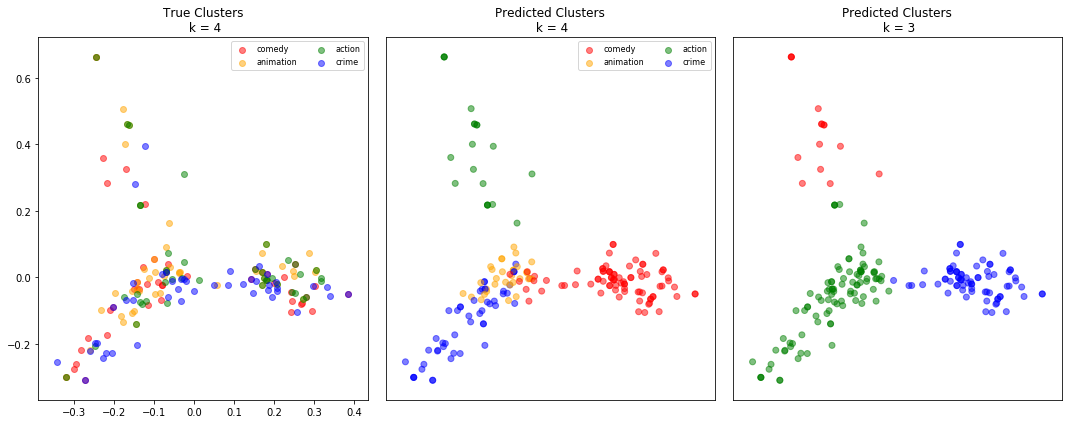

In [17]:
mycolor = ['red','orange','green','blue']
plt.figure(figsize = (15,6))

# True Cluster
plt.subplot(131)
comedy = plt.scatter(reduced_data[colors.index('red'):colors.index('blue')-1, 0], 
                   reduced_data[colors.index('red'):colors.index('blue')-1, 1], color=mycolor[0],alpha = 0.5)
animation = plt.scatter(reduced_data[colors.index('blue'):colors.index('green')-1, 0], 
                   reduced_data[colors.index('blue'):colors.index('green')-1, 1], color=mycolor[1],alpha = 0.5)
action = plt.scatter(reduced_data[colors.index('green'):colors.index('orange')-1, 0], 
                   reduced_data[colors.index('green'):colors.index('orange')-1, 1], color=mycolor[2],alpha = 0.5)
crime = plt.scatter(reduced_data[colors.index('orange'):, 0], 
                   reduced_data[colors.index('orange'):, 1], color=mycolor[3],alpha = 0.5)
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster 4 clusters
plt.subplot(132)
colors_p = [colordict[category[l]] for l in km.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('Predicted Clusters\n k = 4')

# Predicted Cluster 3 clusters
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(MovieTFVects.toarray())
#Movie_Kingdom['Kmeans Prediction 3'] = km3.labels_
plt.subplot(133)
colors_p3 = [colordict[category[l]] for l in km3.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')

plt.tight_layout()
plt.show()

### <span style="color:purple"> Flat Clustering Plot Analysis
<span style="color:purple">**True Clusters** <br>
<span style="color:purple">Dots with different colors mix with each other. This maybe due to two reasons. First, though a movie is categorized to one of the four genres, it could have other genres as well. For instance, a animation could be a comeday simultanously. Hence when the authot is writing the movie critic, he may be very likely to mix genres, which leads to a mixed plot here. A second reason could be that critics itself is unable to be used to identify the movie's genre. <br>
<span style="color:purple">However, a closer observation still tells some interesting things. The red dots (comedy) tend to be closer to the orange dots (animation). This is reasonable. In addition, even though blue dots tend to be everywhere, the biggest clustering of blue dots are at the middle on their own and with a little green dots (action). This reflects that crime is a relatively distinct gnere and some crime moveis could have action genre as well. <br>
<br><span style="color:purple">**Predicted Clusters** <br>
<span style="color:purple">The prediction has to be clear cut, meaning that the computer has to assign one and only one genre to each movie. This breaks the aformentioned *genre-mixture* phenomenon. Hence, the prediction is relatively poor. <br> But there are still interesting findings. First of all, there is only 1 green dot (action), which indicates that the system creates 3 clusters, though the assigned cluster number is 4. This may somewhat reflects the compatability of action movies, which means that an action movie could also be a comedy, or animation, or crime. Moreover, if we see blue and green dots as one group together, it will match the true cluster much better. This could reflect that crime and action are two closer genres as mentioned above. <br>
<span style="color:purple">Hence, I also test the data with 3 clusters. Two groups are now combined together into one as shown in the plot above. 
</span>

In [149]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

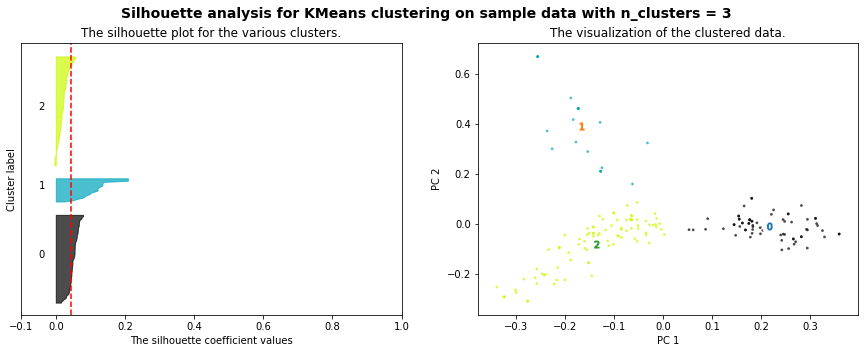

For n_clusters = 3, The average silhouette_score is : 0.043


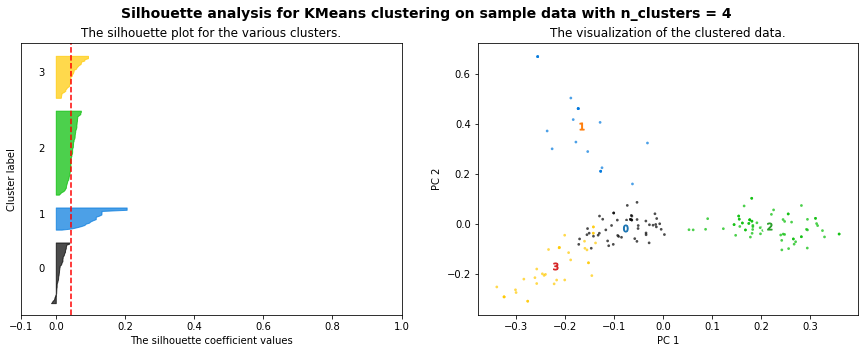

For n_clusters = 4, The average silhouette_score is : 0.044


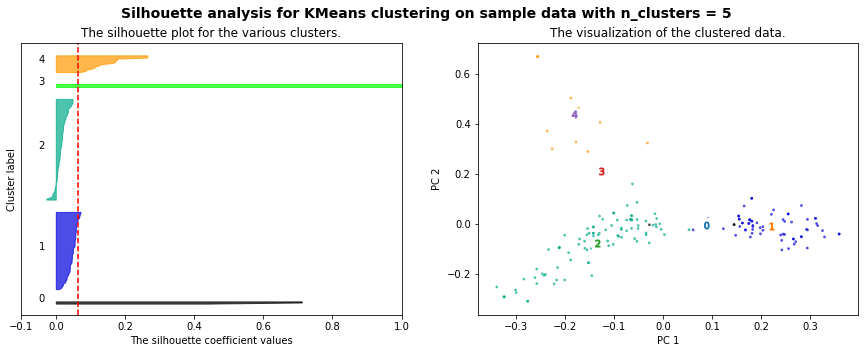

For n_clusters = 5, The average silhouette_score is : 0.066


In [150]:
# Silhouette -- Optimal Number of Clusters
X = MovieTFVects.toarray()
plotSilhouette(3, X)
plotSilhouette(4, X)
plotSilhouette(5, X)

### <span style="color:purple"> Silhouette Analysis Sample </span>
<span style="color:purple"> In this example the silhouette analysis is used to choose an optimal value for n_clusters, 3, 4, and 5, where 4 is the true cluster number. The silhouette plot shows that the n_clusters value of 3 and 5 are poor choice for my Movie_Kingdom dataset. This could be seen from the presence of clusters below average silhouette scores as well as the wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent 4. This well matches the fact.
Also we can visualize the cluster size from the thickness of the silhouette plot. The silhouette plot for cluster 0 and 2 when n_clusters is equal to 3, is bigger in size. Same problems. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right. </span>

# <span style="color:purple"> Hierarchical Clustering Analysis
## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

### <span style="color:purple"> Hierarchical Clustering Approach 1: .dendrogram( ) </span>

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


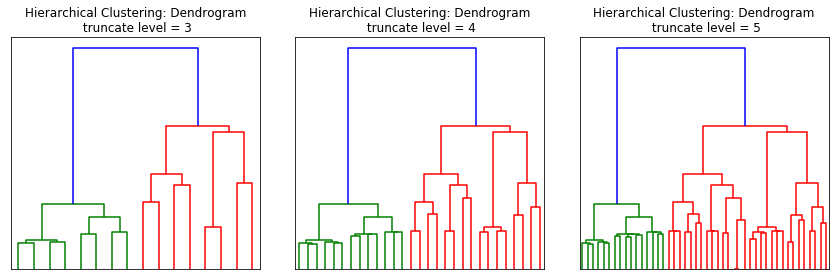

In [151]:
MovieCoocMat = MovieTFVects * MovieTFVects.T
MovieCoocMat.setdiag(0)
linkage_matrix = scipy.cluster.hierarchy.ward(MovieCoocMat.toarray())

plt.figure(figsize = (12,4))

plt.subplot(131)
scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=3, truncate_mode='level', get_leaves=True)
plt.xticks(())
plt.yticks(())
plt.title('Hierarchical Clustering: Dendrogram\n truncate level = 3')

plt.subplot(132)
scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
plt.xticks(())
plt.yticks(())
plt.title('Hierarchical Clustering: Dendrogram\n truncate level = 4')

plt.subplot(133)
scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=5, truncate_mode='level', get_leaves=True)
plt.xticks(())
plt.yticks(())
plt.title('Hierarchical Clustering: Dendrogram\n truncate level = 5')

plt.tight_layout()
plt.show()


### <span style="color:purple"> Dendrogram Analysis Sample </span>
<span style="color:purple"> I have plotted three dendrograms with truncate levels 3, 4, and 5. By default, the tree is colored to show the clusters based on distance. The dendrograms show two colors for branches, namely green and red. This represents two clusters, instead of 4. And in fact the red cluster has two sub-clusters and the green cluster has two sub-clusters, indicating that two movie genres are closer to one another. It actually tends to be reasonable. The four selected genres are action, animation, comedy and crime. As I mentioned repeatedly, the animation and comedy tend to be closer to each other; the crime and the action form another component.

### <span style="color:purple"> Hierarchical Clustering Approach 2: .fcluster( ) </span>

/software/Anaconda3-5.0.0.1-el7-x86_64/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


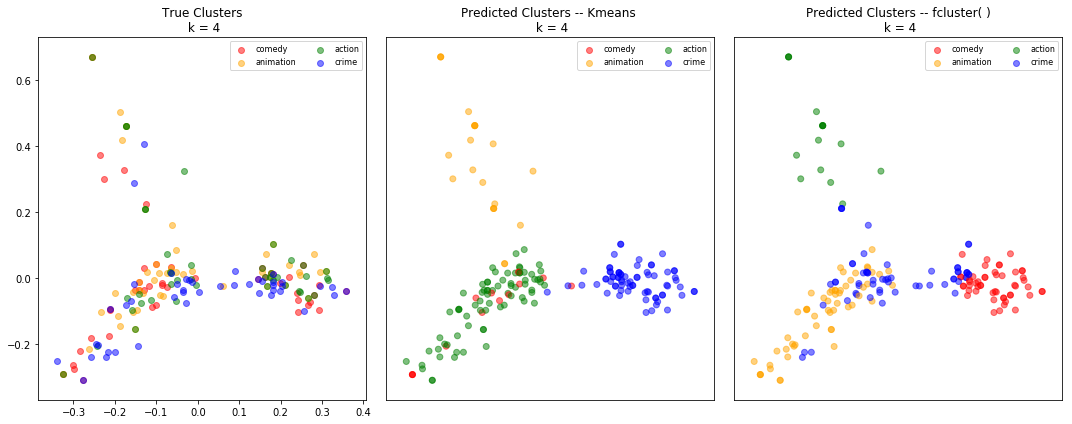

In [152]:
linkage_matrix = scipy.cluster.hierarchy.ward(MovieCoocMat.toarray())
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')

plt.figure(figsize = (15,6))

# True Cluster
plt.subplot(131)
comedy = plt.scatter(reduced_data[colors.index('red'):colors.index('blue')-1, 0], 
                   reduced_data[colors.index('red'):colors.index('blue')-1, 1], color=mycolor[0],alpha = 0.5)
animation = plt.scatter(reduced_data[colors.index('blue'):colors.index('green')-1, 0], 
                   reduced_data[colors.index('blue'):colors.index('green')-1, 1], color=mycolor[1],alpha = 0.5)
action = plt.scatter(reduced_data[colors.index('green'):colors.index('orange')-1, 0], 
                   reduced_data[colors.index('green'):colors.index('orange')-1, 1], color=mycolor[2],alpha = 0.5)
crime = plt.scatter(reduced_data[colors.index('orange'):, 0], 
                   reduced_data[colors.index('orange'):, 1], color=mycolor[3],alpha = 0.5)
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster 4 clusters -- Kmeans
plt.subplot(132)
colors_p = [colordict[category[l]] for l in km.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('Predicted Clusters -- Kmeans \n k = 4')


# Predicted Cluster 4 clusters -- fcluster ()
Movie_Kingdom['wald_predictions'] = hierarchicalClusters
#Movie_Kingdom['Kmeans Prediction 3'] = km3.labels_
plt.subplot(133)
colors_f = [colordict[category[l]] for l in hierarchicalClusters-1]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_f, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters -- fcluster( )\n k = 4')
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)

plt.tight_layout()
plt.show()

### <span style="color:purple"> Hierarchical Clustering Plot Analysis
<span style="color:purple">**Predictions of .fcluster( )** <br>
<span style="color:purple"> This plot includes 3 subplots, namely the true clusters, the predicted flat clusters by kmeans, and the predicted hierarchical clusters by fcluster(). I have analyzed that the kmeans method performs poor here. However, the hierarchical cluster by fcluster() seems to give a better prediction. It correctly predicts those crime movies (blue dots) and many animation movies (orange movies). Some animation movies have been labeled as comedies, which may indicate the closeness between these two genres. Analogously, a crime movie is rarely labeled another genre, which shows the distinction of this genre. Only several blue dots (crime movies) have been colored into green (action). Several red dots (comedy) have been classified into green dots (action), which tells that movies may have both genres. <br> <br>
<span style="color:purple">**kmeans vs .fcluster( )**<br>
That the .fcluster( ) overperforms kmeans is unexpected. This is not only because the kmeans methods tends to be more efficient in general, but also the "flatness" of 4 genres being chosen. Specifically, these 4 genres are on the some level with no hierarchy. However, the *genre-mixture* phenomenon may be the counfunding factors that keep the programming from cluster the movie critics acurately.

In [153]:
print('Cluster Evaluation -- Kmeans')
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Movie_Kingdom['Movie Category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Movie_Kingdom['Movie Category'], km.labels_)))
print('\n')
print("Cluster Evaluation -- fcluster():")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(Movie_Kingdom['Movie Category'], hierarchicalClusters)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(Movie_Kingdom['Movie Category'], hierarchicalClusters)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(Movie_Kingdom['Movie Category'], hierarchicalClusters)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(Movie_Kingdom['Movie Category'], hierarchicalClusters)))

Cluster Evaluation -- Kmeans
Homogeneity: 0.040
Completeness: 0.047
V-measure: 0.043
Adjusted Rand Score: 0.007


Cluster Evaluation -- fcluster():
Homogeneity: 0.033
Completeness: 0.035
V-measure: 0.034
Adjusted Rand Score: 0.019


### <span style="color:purple"> Analysis of the Metrics Results </span>
<span style="color:purple">I list out the metrics for both kmeans and fcluster( ). As mentioned above, the clustering plots show that fcluster( ) gives a better prediction. This could be read from statistics as well. See the values of homogeneity, completeness, v-measure, and adjusted rand score. All four metrics of fcluster( ) are much larger than those of kmeans.

# <span style="color:purple"> Topic Modeling
## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

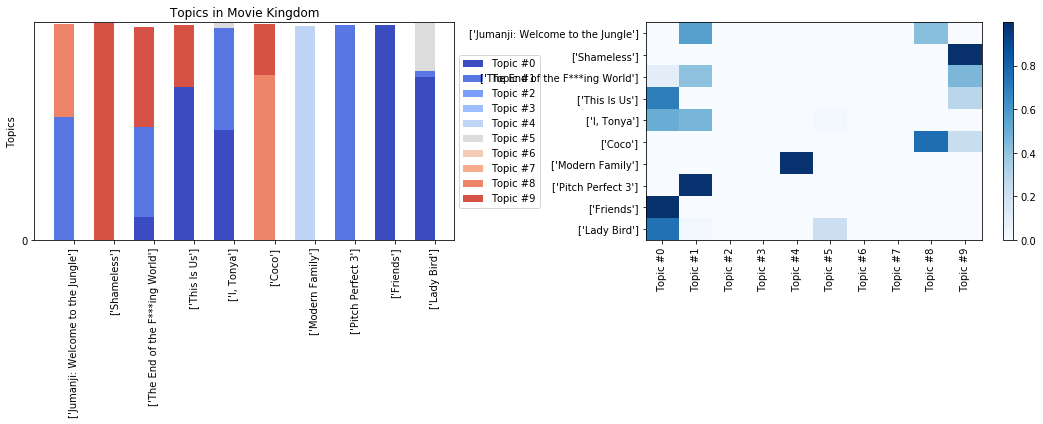

In [154]:
# firstly, create a dictionary -- tokenize, nomalize, reduce by dropping missing values
Movie_Kingdom['Tokenized Text'] = Movie_Kingdom['Movie Critic'].apply(lambda x: nltk.word_tokenize(x))
Movie_Kingdom['Normalized Tokens'] = Movie_Kingdom['Tokenized Text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                 stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                 stemmer = lucem_illud.stemmer_basic))


def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
Movie_Kingdom['Reduced Tokens'] = Movie_Kingdom['Normalized Tokens'].apply(lambda x: dropMissing(x, MovieTFVectorizer.vocabulary_.keys()))
dictionary = gensim.corpora.Dictionary(Movie_Kingdom['Reduced Tokens'])

# secondly, create a corpus -- a list a tuples containing each token and its count
corpus = [dictionary.doc2bow(text) for text in Movie_Kingdom['Reduced Tokens']]

# thirdly, serialize the corpus as a file and load it (especially important when the corpus is large)
gensim.corpora.MmCorpus.serialize('Critic.mm', corpus)
criticmm = gensim.corpora.MmCorpus('Critic.mm')

# Inspect the degree to which distinct texts load on different topics. 
# set the num_topics = 10
Movielda = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')
Movie1Bow = dictionary.doc2bow(Movie_Kingdom['Reduced Tokens'][0])
Movie1lda = Movielda[Movie1Bow]

ldaDF = pandas.DataFrame({
        'name' : Movie_Kingdom['Movie Title'],
        'topics' : [Movielda[dictionary.doc2bow(l)] for l in Movie_Kingdom['Reduced Tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(Movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(Movielda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]


plt.figure(figsize = (15,6))

# Plot the Bar Chart -- topic number is 10
plt.subplot(121)
# Preparation for Bar Chart
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV
N = 10
ind = np.arange(N)
K = Movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')  
plt.title('Topics in Movie Kingdom')  
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')
plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]  
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))


# Plot the Heat Map
plt.subplot(122)

# Preparation for Heat Map
topicsDict = {}
for topicNum in range(Movielda.num_topics):
    topicWords = [w for w, p in Movielda.show_topic(topicNum, 50)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)  #### **** This is the list of each topics

plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);
plt.gca().invert_yaxis()  # flip the y-axis so the texts are in the order we anticipate
plt.xticks(rotation=90) # rotate the ticks on the x-axis
plt.colorbar(cmap='Blues')  # add a legend
plt.tight_layout()  # fixes margins

plt.tight_layout()
plt.show()

### <span style="color:purple"> Analysis of Topic Modeling </span>
<span style="color:purple">**Topic Modeling -- topic_num = 10**<br>
I first set the number of topics to be 10. <br>
    
<span style="color:purple">**Topic Modeling -- Bar Chart**<br>
The bar chart shows the topics allocation of each movie critic. Generally, one movie critic has been assigned 1~3 topics. This matches the fact quite well because a movie usually has this number of genres. The bar chart only shows 10 movies. All of them are comedies. Hence, it's normal to see most of them have blue color as the dominant color, except movie *Shameless* and *Pitch Perfect*. <br>

<span style="color:purple">**Topic Modeling -- Heat Map**<br>
Heat map provides more information than the bar chart. It not only shows which topics have been allocated to each movie critic, but also shows how close the movie critic to each assigned topic. The results are desirable. Specifically, this heat map displays 10 movies which all come from the category "comedy". As we could see that almost every movie has been assigned to the same topics -- topic 4 and (or) 6. 
<span style="color:purple"> If I just open the topic 4 and 6 lists. The top terms are "season", "love", "play", and "thing". These key words do not well match the genre itself. <br> 
<span style="color:purple"> However, as you may notice, topics 2, 7, 9 correspond to a white column, which means that none of the movie critics have these topics. To reduce the dimensionaliry and check other number of topics, I could explore by changing the number of topics to be 5.

In [155]:
# We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. 
# To look at the terms with the highest LDA weight in topic `1` we can do the following:
Movielda.show_topic(4)    

[('season', 0.02061997),
 ('watch', 0.015618307),
 ('work', 0.012396307),
 ('think', 0.010668213),
 ('come', 0.0101809325),
 ('play', 0.0097451275),
 ('thing', 0.009706175),
 ('say', 0.008806048),
 ('star', 0.008615067),
 ('review', 0.007881238)]

Text(0.5,1,'Probability Distribution of Words, Topic 1, $\\eta$ = 0.9')

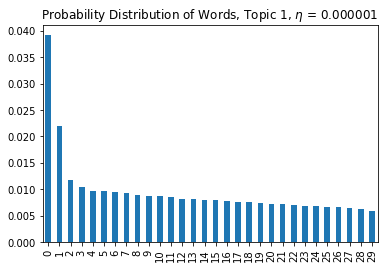

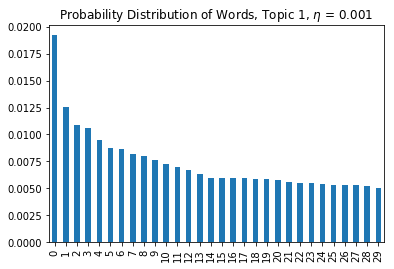

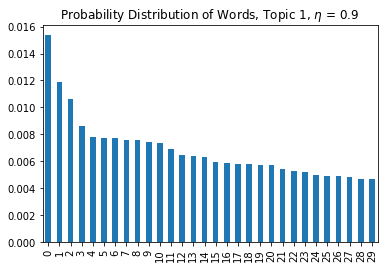

In [156]:
Movielda  =  gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, eta=0.000001)
Movielda_1 = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, eta = 0.001)
Movielda_2 = gensim.models.ldamodel.LdaModel(corpus=criticmm, id2word=dictionary, num_topics=10, eta = 0.9)

# True Cluster
#plt.subplot(131)
topic1_df = pandas.DataFrame(Movielda.show_topic(1, topn=30))
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1, $\eta$ = 0.000001')

#plt.subplot(132)
topic1_df_1 = pandas.DataFrame(Movielda_1.show_topic(1, topn=30))
topic1_df_1.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1, $\eta$ = 0.001')

#plt.subplot(133)
topic1_df_2 = pandas.DataFrame(Movielda_2.show_topic(1, topn=30))
topic1_df_2.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1, $\eta$ = 0.9')

### <span style="color:purple"> Gensim Topic Modeling with Different Parameters </span>

<span style="color:purple">I changed the number of topics in the heat plots above because some topics are of little use. There is another way to adjust the topic model and make the topics more distinct -- change the $\alpha$ and $\eta$ parameters of the model. <br>
To See how different $\eta$ values will change the shape of the distribution, I plot three topic models with $\eta$ being {0.9, 0.001, 0.00001} $\eta$ controls the sparsity of topic-word loadings. Hence a small $\eta$ value means that it will be more sparse. So the biggest $\eta$ value here, 0.9, has a flatter probability distribution of words.

In [157]:
topicsDict = {}
for topicNum in range(Movielda.num_topics):
    topicWords = [w for w, p in Movielda.show_topic(topicNum, 183)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
wordRanksDF = pandas.DataFrame(topicsDict)  #### **** This is the list of each topics

Topics_all = []
x=0
for j in range(183):
    topic_per_critics = ''
    for i in range(0,10):
        topic = 'Topic_'+str(i)
        topic_per_critics += ' ' + wordRanksDF[topic][j]
    Topics_all.append(topic_per_critics)        
Movie_Kingdom['Movie Critic Topics'] = Topics_all

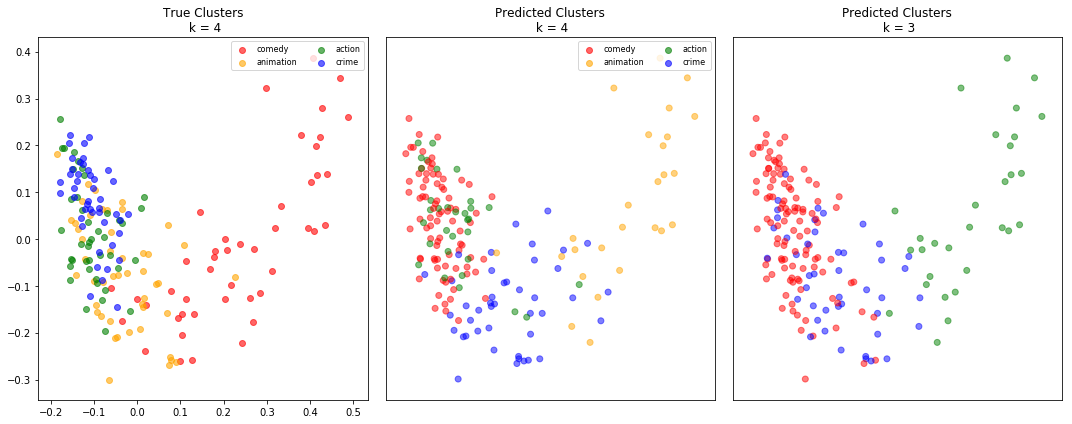

In [158]:
MovieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=200, min_df=1, stop_words='english', norm='l2')
MovieTFVects = MovieTFVectorizer.fit_transform(Movie_Kingdom['Movie Critic Topics'])
# number of clusters
num_Clusters = len(set(Movie_Kingdom['Movie Category']))

# initialize K-means
km = sklearn.cluster.KMeans(n_clusters=num_Clusters, init='k-means++')
km.fit(MovieTFVects)

# predict the k-means
Movie_Kingdom['Kmeans Prediction by Topic'] = km.labels_

# PCA to reduce the dimensionality
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(MovieTFVects.toarray())
reduced_data = pca.transform(MovieTFVects.toarray())
components = pca.components_
#keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]
#plt.scatter(x,y)
colordict = {
'comedy': 'red',
'animation': 'orange',
'action': 'green',
'crime': 'blue',
    }
colors = [colordict[c] for c in Movie_Kingdom['Movie Category']]

mycolor = ['red','orange','green','blue']
plt.figure(figsize = (15,6))

# True Cluster
plt.subplot(131)
comedy = plt.scatter(reduced_data[colors.index('red'):colors.index('blue')-1, 0], 
                   reduced_data[colors.index('red'):colors.index('blue')-1, 1], color=mycolor[0],alpha = 0.6)
animation = plt.scatter(reduced_data[colors.index('blue'):colors.index('green')-1, 0], 
                   reduced_data[colors.index('blue'):colors.index('green')-1, 1], color=mycolor[1],alpha = 0.6)
action = plt.scatter(reduced_data[colors.index('green'):colors.index('orange')-1, 0], 
                   reduced_data[colors.index('green'):colors.index('orange')-1, 1], color=mycolor[2],alpha = 0.6)
crime = plt.scatter(reduced_data[colors.index('orange'):, 0], 
                   reduced_data[colors.index('orange'):, 1], color=mycolor[3],alpha = 0.6)
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('True Clusters\n k = 4')

# Predicted Cluster 4 clusters
plt.subplot(132)
colors_p = [colordict[category[l]] for l in km.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.legend((comedy, animation, action, crime),
          ('comedy','animation','action','crime'),
          scatterpoints=1,
          loc = 'upper right',
          ncol =2,
          fontsize = 8)
plt.title('Predicted Clusters\n k = 4')

# Predicted Cluster 3 clusters
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(MovieTFVects.toarray())
#Movie_Kingdom['Kmeans Prediction 3'] = km3.labels_
plt.subplot(133)
colors_p3 = [colordict[category[l]] for l in km3.labels_]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p3, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')

plt.tight_layout()
plt.show()

### <span style="color:purple"> Strech Analysis </span>
<span style="color:purple"> Instead of using words alone I cluster my documents by using their topic loadings as an additional set of features. This gives a better prediction! Specifically, the distinct crime genre has been well identified. Most of the animation movies have been identified, leaving part of them to be categoried under comedy, which is totally possible. A major disadvantage is that many of the comedy movies have been identified as action movies. 
Therefore, taking the movie topics into account, the clustering prediction tends to get better!

# <span style="color:purple"> APPENDIX: Web Scraping Code

In [159]:
"""
category = ['comedy','crime','action','animation']
# tail[1]: comedy; tail[2]: crime; tail[3]: action; tail[4]:animation

Movie_Title = []
Movie_Genre = []
Movie_Critic = []
Movie_Category = []

num_page = 1

for i in range(0,4):  # for loop for the 4 categories -- i category    
    for j in range(1,num_page+1):  # for loop for the pages of category i (each page contains 50 movies) -- j num_page
        print('enter a page', j, 'in category', category[i])
        heading = 'http://www.imdb.com/search/title?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=2251824562&pf_rd_r=0DP960VPZ9A5CFX59VGA&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=moviemeter&genres='
        url = heading + category[i] + '&explore=title_type,genres&page=' + str(j) + '&ref_=adv_nxt'
        response = get(url)
        beautiSoup = BeautifulSoup(response.text, 'html.parser')
        movie_tank = beautiSoup.find_all('div', class_ = 'lister-item mode-advanced')
        for k in range(0,50):  # for loop for the 50 movies on page j -- k movie
            print('enter a movie', k)
            
            # movie_id
            movie_link = 'http://www.imdb.com/' + movie_tank[k].h3.a.get('href')      # <<--- change 0 to k
            movie_id = re.search(r'tt\d+', movie_link).group(0)

            # movie critic
            critic_page_link = 'http://www.imdb.com/title/' + movie_id + '/externalreviews?ref_=tt_ov_rt'
            response_2 = get(critic_page_link)
            beautiSoup_2 = BeautifulSoup(response_2.text, 'html.parser')
            critic_list = beautiSoup_2.find_all('a', attrs = {'href': re.compile('^\/offsite\/\?page\-action\=offsite\-')})
            # need to check the URLErro
            def CheckError(url):
                try: 
                    urllib.request.urlopen(url)
                    #response = get(url) 
                    #html=urlopen(url)
                except urllib.error.HTTPError as e:
                    return -1
                except urllib.error.URLError as e:
                    print('url error')
                    return -2
                return 1
            if CheckError(critic_page_link) < 0:
                print('critic page cannot be opened')
            else: 

                if critic_list == []:
                    print('no critic for category', category[i], 'for movie', k, 'on page', j)
                else:
                    # Find one critic will be good.
                    # However, I have to find a critic in English.
                    # Therefore, I will build a loop until the first English page critic is obtained.
                    gotIt = 0
                    n = 0
                    max_n = len(critic_list)
                    critic = []
                    while gotIt == 0 and n < max_n:
                        critic_name = critic_list[n].text
                        a = re.search(r'\(', critic_name) 
                        if a is None: 
                            #print('english!')
                            #gotIt = 1
                            critic_link = 'http://www.imdb.com' + critic_list[n].get('href')
                            response_3 = get(critic_link)
                            beautiSoup_3 = BeautifulSoup(response_3.text, 'html.parser')
                            paragraph = beautiSoup_3.find_all('p')
                            if len(paragraph) > 15: # have enough paragraphs
                                for p in paragraph:
                                    if len(p.text) >100: # eliminate noises
                                        critic.append(p.text)
                                gotIt = 1
                            else:
                                n += 1
                                print('too short')      
                        else:
                            print('nonEnglish!')
                            n += 1
                    Movie_Critic.append(critic)   #**

                    # movie title
                    title = movie_tank[k].h3.a.text   # <<--- change 0 to k
                    Movie_Title.append(title) #**

                    # movie genres
                    genre = []
                    response_1 = get(movie_link)
                    beautiSoup_1 = BeautifulSoup(response_1.text, 'html.parser')
                    genre_list = beautiSoup_1.find('div', class_="see-more inline canwrap", attrs = {'itemprop':"genre"})
                    genre_item = genre_list.find_all('a')
                    for item in genre_item:
                        genre.append(item.text)
                    Movie_Genre.append(genre) #**

                    # Movie Category
                    Movie_Category.append(category[i])
                    #print('OKOKOKOKOKO')
                    
Movie_Kingdom = pandas.DataFrame({'Movie Title': Movie_Title,
                                  'Movie Category': Movie_Category,
                                  'Movie Genre': Movie_Genre,
                                  'Movie Critic': Movie_Critic})
Movie_Kingdom.to_csv('MovieKingdom.csv', sep=',')
Movie_Kingdom.to_excel('MovieKingdom.xlsx','Sheet1')                    

"""

enter a page 1 in category comedy
enter a movie 0
enter a movie 1
enter a movie 2
nonEnglish!
too short
enter a movie 3
too short
nonEnglish!
too short
nonEnglish!
enter a movie 4
enter a movie 5
enter a movie 6
too short
too short
enter a movie 7
enter a movie 8
too short
too short
too short
too short
too short
too short
too short
too short
too short
too short
too short
nonEnglish!
enter a movie 9
enter a movie 10
too short
enter a movie 11
enter a movie 12
enter a movie 13
enter a movie 14
enter a movie 15
enter a movie 16
enter a movie 17
enter a movie 18
enter a movie 19
too short
too short
too short
too short
too short
too short
too short
too short
too short
nonEnglish!
enter a movie 20
enter a movie 21
enter a movie 22
nonEnglish!
nonEnglish!
enter a movie 23
enter a movie 24
enter a movie 25
enter a movie 26
enter a movie 27
enter a movie 28
enter a movie 29
no critic for category comedy for movie 29 on page 1
enter a movie 30
nonEnglish!
enter a movie 31
enter a movie 32
enter 